### Задача на обучение с подкреплением. Описание.
Реализация алгоритмов DDPG и TD3. Тестирование проводится с помощью одной из классических сред LunarLanderContinuous, которая входит в библиотеку OpenAI Gym.


In [ ]:
#!pip install Box2D  > /dev/null 2>&1
#!pip install gym[all] pyvirtualdisplay > /dev/null 2>&1
#!pip install tqdm > /dev/null 2>&1
#!apt update > /dev/null 2>&1
#!apt install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
import gym
import time
import matplotlib.pyplot as plt
import copy
import random
import numpy as np
from collections import deque

# PyTorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from tqdm.notebook import tqdm

device = torch.device("cuda") 

%matplotlib inline

In [ ]:
#@title Буфер опыта

class ExpirienceReplay:
    def __init__(self, size=10000):
        self.data = deque(maxlen=size)
    
    def add(self, transition):
        self.data.append(transition)
        
    def sample(self, size):
        batch = random.sample(self.data, size)
        return list(zip(*batch))

In [ ]:
#@title Метод build_plot для отрисовки графиков

def build_plot(xs, means, stds, labels, figsize=(12, 8)):
    colors = [
        (0.8, 0.0, 0.0),
        (0.0, 0.8, 0.0),
        (0.0, 0.0, 0.8),
        (0.0, 0.5, 0.8)
    ]
    x_min = max([x[0] for x in xs])
    x_max = min([x[-1] for x in xs])
    plt.figure(figsize=figsize)
    plt.plot([x_min, x_max], [150., 150.], color=(0.25, 0.25, 0.25, 0.6), linestyle='-.', label="Minimal solution")
    plt.plot([x_min, x_max], [300., 300.], color=(0.75, 0.75, 0.0, 0.6), linestyle='-.', label="Optimal solution")
    for x, mean, std, label, color in zip(xs, means, stds, labels, colors):
        plt.fill_between(x, mean - 2*std, mean + 2*std, color=color, alpha=0.2)
        plt.plot(x, mean, label=label, color=color)
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.ylim(-300, 300)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
#@title Методы train и test

ACTION_SIZE = 2
STATE_SIZE = 8
ENV_NAME = "LunarLanderContinuous-v2"

def test(ddpg, episodes=10):
    rewards = []    
    env = gym.make(ENV_NAME)
    for _ in range(episodes):
        sum_reward = 0
        done = False
        state = env.reset()
        while not done:
            state, reward, done, _ = env.step(ddpg.get_action(state))
            sum_reward += reward
        rewards.append(sum_reward)
    return np.mean(rewards), np.std(rewards)

def train(agent, timesteps=50000, batch_size=256, buffer_size=50000, 
          start_train=10000, test_every=1000, test_count=10):
    env = gym.make(ENV_NAME)
    env.seed(0)
    random.seed(0)
    done = False
    state = env.reset()
    buffer = ExpirienceReplay(buffer_size)
    actor_loss_sum = 0
    critic_loss_sum = 0
    loss_ctn = 0
    
    log_ts = []
    log_mean = []
    log_std = []
    
    rng = tqdm(range(timesteps))
    for t in rng:
        if done:
            done = False
            state = env.reset()
        action = np.clip(agent.get_action(state) + np.random.randn(ACTION_SIZE)*0.15, -1, 1)
        next_state, reward, done, _ = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
        
        if t > start_train:
            batch = buffer.sample(batch_size)
            critic_loss, actor_loss = agent.update(batch, t)
            actor_loss_sum += actor_loss
            critic_loss_sum += critic_loss
            loss_ctn += 1
            
            if t % test_every == 0 or t == timesteps - 1:
                log_ts.append(t)
                mean, std = test(agent, test_count)
                log_mean.append(mean)
                log_std.append(std)
                rng.set_postfix_str(f"Mean reward: {mean:.2f}, Critic loss: {(critic_loss_sum / loss_ctn):.2f}, Actor loss: {(actor_loss_sum / loss_ctn):.2f}")
                actor_loss_sum = 0
                critic_loss_sum = 0
                loss_ctn = 0
    return np.array(log_ts), np.array(log_mean), np.array(log_std)

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(Actor, self).__init__()
        
        self.fc1 = nn.Linear(state_size, hidden_size)
        f1 = 1 / np.sqrt(self.fc1.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        torch.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(hidden_size)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        f2 = 1 / np.sqrt(self.fc2.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        torch.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.bn2 = nn.LayerNorm(hidden_size)
        
        f3 = 0.003
        self.mu = nn.Linear(hidden_size, action_size)
        torch.nn.init.uniform_(self.mu.weight.data, -f3, f3)
        torch.nn.init.uniform_(self.mu.bias.data, -f3, f3)


    def forward(self, state):

        x = self.bn1(self.fc1(state))
        x = F.relu(x)
        x = self.bn2(self.fc2(x))
        x = F.relu(x)
        x = torch.tanh(self.mu(x))
        return x

In [ ]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(Critic, self).__init__()
        
        self.fc1 = nn.Linear(state_size, hidden_size)
        f1 = 1 / np.sqrt(self.fc1.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        torch.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(hidden_size)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        f2 = 1 / np.sqrt(self.fc2.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        torch.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.bn2 = nn.LayerNorm(hidden_size)
        
        self.action_value = nn.Linear(action_size, hidden_size)

        f3 = 0.003
        self.q = nn.Linear(hidden_size, 1)
        torch.nn.init.uniform_(self.q.weight.data, -f3, f3)
        torch.nn.init.uniform_(self.q.bias.data, -f3, f3)
        
    def forward(self, state, action):

        state_value = self.bn1(self.fc1(state))
        state_value = F.relu(state_value)
        state_value = self.bn2(self.fc2(state_value))
        #state_value = F.relu(state_value)

        action_value = F.relu(self.action_value(action))
        state_action_value = F.relu(torch.add(state_value, action_value))
        state_action_value = self.q(state_action_value)

        return state_action_value

In [ ]:
class DDPG:
    def __init__(self, state_size, action_size, tau=0.001, gamma=0.99, hidden_size=256):
        self.gamma = gamma
        self.tau = tau
        self.actor = Actor(state_size, action_size)
        self.critic = Critic(state_size, action_size)
        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)
        
        self.actor.to(device)
        self.target_actor.to(device)
        self.critic.to(device)
        self.target_critic.to(device)
        
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=1e-4)
        
    def get_action(self, state):

        self.actor.eval()
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        state = state.to(device)
        action = self.actor.forward(state).to(device)
        self.actor.train()
        return action.cpu().detach().squeeze(0).numpy()
    
    def compute_actor_loss(self, state):

        self.actor.eval()
        self.critic.eval()
        mu = self.actor.forward(state)
        actor_loss = -self.critic.forward(state, mu)
        actor_loss = torch.mean(actor_loss)
        self.actor.train()
        self.critic.train()
        return actor_loss
    
    def compute_critic_loss(self, state, action, next_state, reward, done):

        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()

        target_actions = self.target_actor.forward(next_state)
        target_critic_values = self.target_critic.forward(next_state, target_actions)
        critic_values = self.critic.forward(state, action)

        done = done.long().unsqueeze(1)
        reward = reward.unsqueeze(1)
        target_values = reward + self.gamma * (1 - done) * target_critic_values
                
        critic_loss = F.mse_loss(target_values, critic_values)

        self.critic.train()
        return critic_loss
    
    def soft_update(self, target_net, source_net):
        for target_params, params in zip(target_net.parameters(), source_net.parameters()):
          target_params.data.copy_(self.tau * params.data + (1 - self.tau) * target_params.data)
        
    
    def update(self, batch, step):
        state, action, next_state, reward, done = batch
        state = torch.tensor(state, dtype=torch.float32, device=device)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device).view(-1)
        done = torch.tensor(done, device=device)
        action = torch.tensor(action, device=device, dtype=torch.float32)
        
        actor_loss = self.compute_actor_loss(state)
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        # Actor soft update
        self.soft_update(self.target_actor, self.actor)

        critic_loss = self.compute_critic_loss(state, action, next_state, reward, done)
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()
            
        # Critic soft update
        self.soft_update(self.target_critic, self.critic)

        return critic_loss.item(), actor_loss.item()

In [ ]:
class TD3(DDPG):
    def __init__(self, state_size, action_size, tau=0.001, gamma=0.99, hidden_size=256, policy_delay=2, policy_noise=0.2, noise_clip=0.5):
        super().__init__(state_size, action_size, tau, gamma, hidden_size)
        self.policy_delay = policy_delay
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip

        self.critic_2 = copy.deepcopy(self.critic)
        self.critic_2.to(device)
        
        self.target_critic_2 = copy.deepcopy(self.critic)
        self.target_critic_2.to(device)

        self.critic_optim_2 = optim.Adam(self.critic_2.parameters(), lr=1e-4)
    
    def compute_critic_loss(self, state, action, next_state, reward, done):

        self.critic.eval()
        self.critic_2.eval()
        self.target_actor.eval()
        self.target_critic.eval()
        self.target_critic_2.eval()

        noise = torch.clamp(torch.randn_like(action) * self.policy_noise, -self.noise_clip, self.noise_clip)
        next_action = torch.clamp(self.target_actor(next_state) + noise, -1, 1)

        critic_values = self.critic(state, action)
        critic_values_2 = self.critic_2(state, action)

        target_critic_values = self.target_critic(next_state, next_action)
        target_critic_values_2 = self.target_critic_2(next_state, next_action)

        min_values = torch.min(target_critic_values, target_critic_values_2)

        done = done.long().unsqueeze(1)
        reward = reward.unsqueeze(1)
        target_values = reward + self.gamma * (1 - done) * min_values

        critic_loss = F.mse_loss(target_values, critic_values)
        critic_loss_2 = F.mse_loss(target_values, critic_values_2)

        self.critic.train()
        self.critic_2.train()

        return critic_loss, critic_loss_2
    
    def update(self, batch, step):
        state, action, next_state, reward, done = batch
        state = torch.tensor(state, dtype=torch.float32, device=device)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device).view(-1)
        done = torch.tensor(done, device=device)
        action = torch.tensor(action, device=device, dtype=torch.float32)
        
        critic_loss, critic_loss_2 = self.compute_critic_loss(state, action, next_state, reward, done)
        self.critic_optim.zero_grad()
        critic_loss.backward(retain_graph=True)
        self.critic_optim.step()

        self.critic_optim_2.zero_grad()
        critic_loss_2.backward()
        self.critic_optim_2.step()

        actor_loss = self.compute_actor_loss(state)
        if step % self.policy_delay == 0:
          #policy update
          self.actor_optim.zero_grad()
          actor_loss.backward()
          self.actor_optim.step()

          # Actor soft update
          self.soft_update(self.target_actor, self.actor)

          # Critic soft update
          self.soft_update(self.target_critic, self.critic)
          self.soft_update(self.target_critic_2, self.critic_2)

        return (critic_loss.item() + critic_loss_2.item()), actor_loss.item()

### Запуск обучения агента

  0%|          | 0/140000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Agent mean score is 159.16375967693926 with std 84.6635955465645


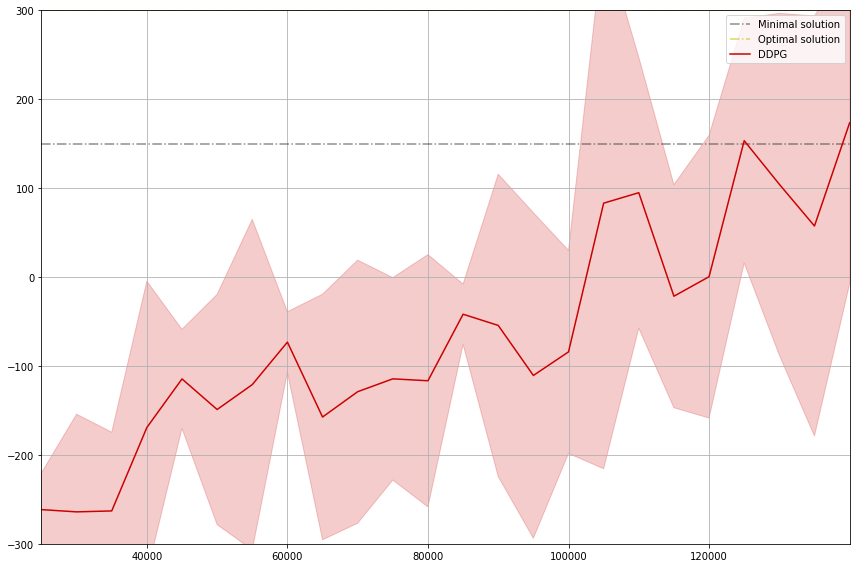

In [ ]:
xs, means, stds, labels = [], [], [], []
ddpg = DDPG(STATE_SIZE, ACTION_SIZE, tau=0.001, gamma=0.99, hidden_size=256)
x, mean, std = train(ddpg, timesteps=140000, test_every=5000,
                    batch_size=128, start_train=20000, buffer_size=50000, test_count=5)
xs.append(x)
means.append(mean)
stds.append(std)
labels.append(f"DDPG")

final_mean, final_std = test(ddpg, episodes=25)
print(f"Agent mean score is {final_mean} with std {final_std}")
build_plot(xs, means, stds, labels)

  0%|          | 0/140000 [00:00<?, ?it/s]

Agent mean score is -48.70435253519753 with std 40.241500515124685


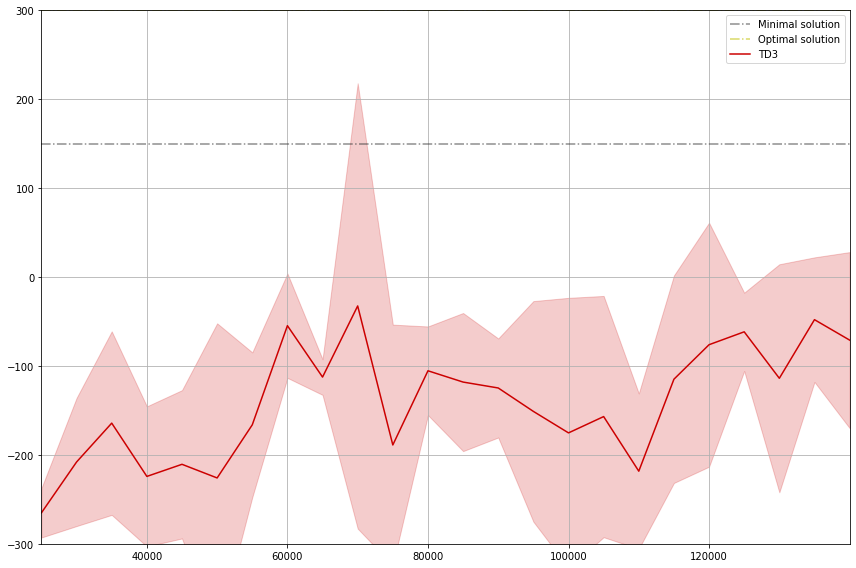

In [ ]:
xs, means, stds, labels = [], [], [], []
td3 = TD3(STATE_SIZE, ACTION_SIZE, tau=0.001, gamma=0.99, hidden_size=256)
x, mean, std = train(td3, timesteps=140000, test_every=5000,
                     batch_size=128, start_train=20000, buffer_size=50000, test_count=5)
xs.append(x)
means.append(mean)
stds.append(std)
labels.append(f"TD3")

final_mean, final_std = test(td3, episodes=25)
print(f"Agent mean score is {final_mean} with std {final_std}")
build_plot(xs, means, stds, labels)

Изменения в значениях параметров tau, start_train, hidden_size не привели к улучшению результатов. Поведение модели показало чуть лучшие результаты со значением batch_size=128. 

Если сравнивать алгоритмы DDPG и TD3, то лучшего результата добиться не удалось, хотя в среднем TD3 показывает значение стандартного отклонения меньше, чем DDPG. TD3 показывает стабильно плохое решение примерно в одном диапазоне (mean score ~ -80), тогда как DDPG может как показать очень хороший результат (mean score ~208), так и очень плохой (mean score ~ -100). 

Например, для аналогичное тестирование, но с tau=0.005, получились следующие результаты:
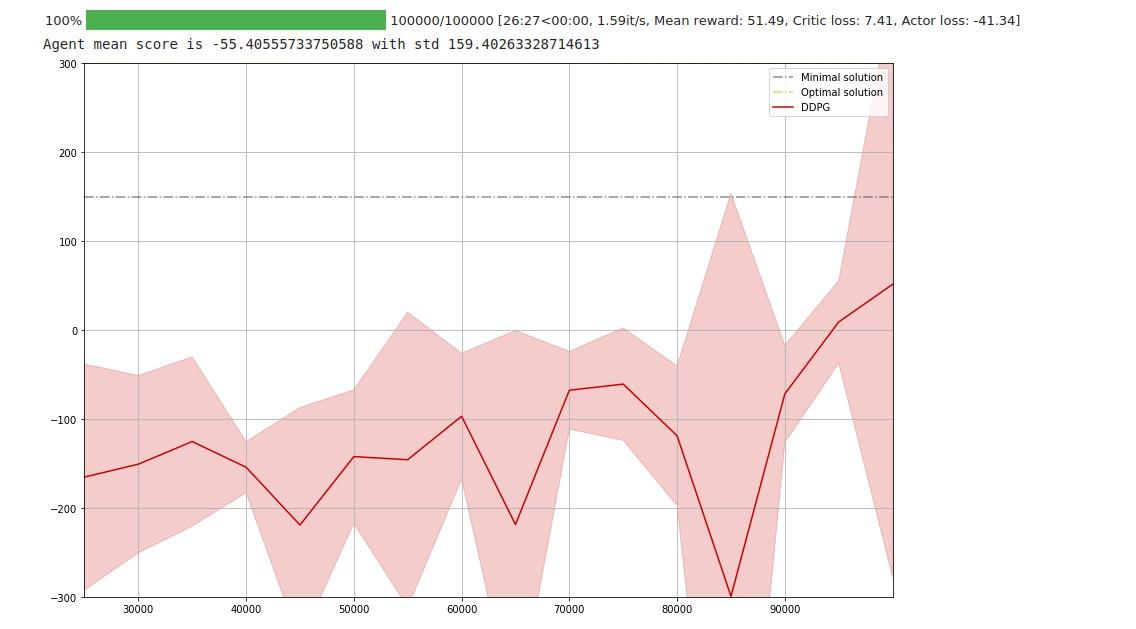


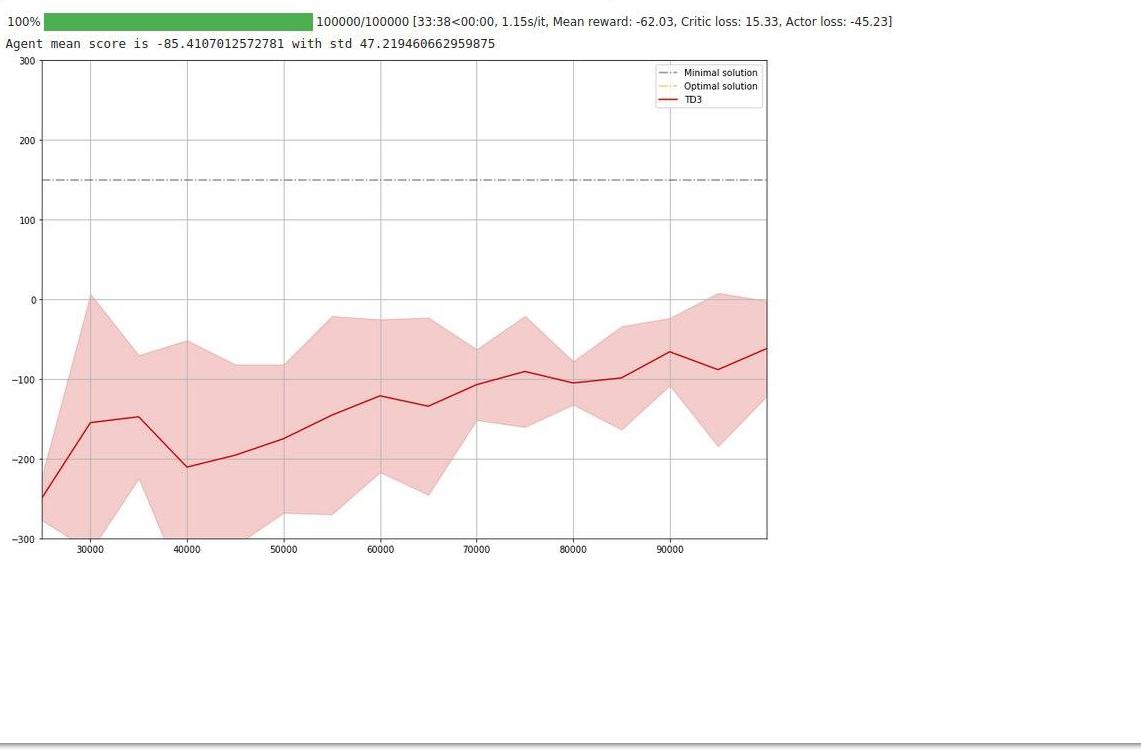
Видимо в обоих моделях происходит сильная переоценка у critic, так как с уменьшением loss значений, не происходит значительного увеличения mean score.

  0%|          | 0/140000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Agent mean score is 61.66537819012826 with std 127.70044021727554


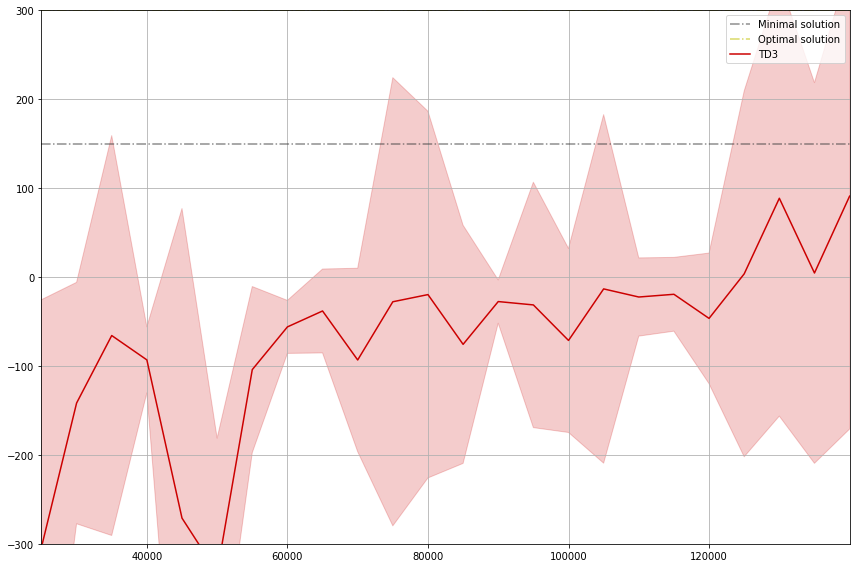

In [ ]:
xs, means, stds, labels = [], [], [], []
td3 = TD3(STATE_SIZE, ACTION_SIZE, tau=0.005, gamma=0.99, hidden_size=256)
x, mean, std = train(td3, timesteps=140000, test_every=5000,
                     batch_size=128, start_train=20000, buffer_size=50000, test_count=5)
xs.append(x)
means.append(mean)
stds.append(std)
labels.append(f"TD3")

final_mean, final_std = test(td3, episodes=25)
print(f"Agent mean score is {final_mean} with std {final_std}")
build_plot(xs, means, stds, labels)